In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
granite = pd.read_csv("/Users/lixinjin/Desktop/GeorgiaTech/fall2022_VIP/Gr1.csv")
granite = granite.iloc[2:102]
# granite.head(5)
granite = granite[[' Hardness(GPa)', ' Modulus', ' X', ' Y']]
granite.rename(columns={' Hardness(GPa)': 'Hardness', ' Modulus': 'Modulus', ' X': 'X', ' Y': 'Y'}, inplace=True)
granite.index = np.arange(1, len(granite) + 1)

granite['X'] = pd.to_numeric(granite['X'])
granite['Y'] = pd.to_numeric(granite['Y'])

granite

,Hardness,Modulus,X,Y
1,0.387642,6.648113,-3.770873,0.002520
2,1.224675,32.848149,-2.771181,0.002699
3,156.045746,1888.860122,-1.771469,0.002709
4,1.841265,37.080645,-0.771161,0.002709
5,10.465644,178.110457,0.228789,0.002699
...,...,...,...,...
96,25.739224,211.007222,1.228045,-8.997162
97,42.664982,681.374523,2.227500,-8.997162
98,63.865255,362.929558,3.227748,-8.997162
99,26.693745,185.871818,4.227718,-8.997162


In [3]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final
granite_new = remove_outlier_IQR(granite)

In [4]:
# granite_new['Hardness'] = np.where(granite_new['Modulus'].isnull(),np.nan, granite_new['Hardness'])
# granite_new['Modulus'] = np.where(granite_new['Hardness'].isnull(),np.nan, granite_new['Modulus'])

granite_new['Modulus'] = granite_new['Modulus'].interpolate(axis = 0) # default method: linear
granite_new['Hardness'] = granite_new['Hardness'].interpolate(axis = 0) # default method: linear
granite_new # outliers problem

,Hardness,Modulus,X,Y
1,0.387642,6.648113,-3.770873,0.002520
2,1.224675,32.848149,-2.771181,0.002699
3,1.532970,34.964397,-1.771469,0.002709
4,1.841265,37.080645,-0.771161,0.002709
5,10.465644,178.110457,0.228789,0.002699
...,...,...,...,...
96,25.739224,211.007222,1.228045,-8.997162
97,42.664982,286.968390,2.227500,-8.997162
98,34.679363,362.929558,3.227748,-8.997162
99,26.693745,185.871818,4.227718,-8.997162


In [5]:
granite_removed_1 = granite_new

x_diff = granite_removed_1["X"].max() - granite_removed_1["X"].min()
granite_removed_1["X"] = (granite_removed_1["X"].sub(granite_removed_1["X"].min(), fill_value=0)) / x_diff
y_diff = granite_removed_1["Y"].max() - granite_removed_1["Y"].min()
granite_removed_1["Y"] = (granite_removed_1["Y"].sub(granite_removed_1["Y"].min(), fill_value=0)) / y_diff

hardness_diff = granite_removed_1["Hardness"].max() - granite_removed_1["Hardness"].min()
granite_removed_1["Hardness"] = (granite_removed_1["Hardness"].sub(granite_removed_1["Hardness"].min(), fill_value=0)) / hardness_diff
modulus_diff = granite_removed_1["Modulus"].max() - granite_removed_1["Modulus"].min()
granite_removed_1["Modulus"] = (granite_removed_1["Modulus"].sub(granite_removed_1["Modulus"].min(), fill_value=0)) / modulus_diff

In [6]:
granite_removed_1

,Hardness,Modulus,X,Y
1,0.000517,0.000000,0.000052,0.999979
2,0.017389,0.073537,0.111125,0.999999
3,0.023602,0.079477,0.222200,1.000000
4,0.029816,0.085417,0.333341,1.000000
5,0.203648,0.481255,0.444443,0.999999
...,...,...,...,...
96,0.511500,0.573589,0.555467,0.000000
97,0.852654,0.786794,0.666513,0.000000
98,0.691697,1.000000,0.777648,0.000000
99,0.530740,0.503040,0.888752,0.000000


In [7]:
# GMM
from sklearn.mixture import GaussianMixture 
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
import scipy as sp
import scipy.interpolate
from scipy.interpolate import griddata
roundset = granite_removed_1
roundset['X'] = round(roundset['X'], 2)
roundset['Y'] = round(roundset['Y'], 2)
roundset

,Hardness,Modulus,X,Y
1,0.000517,0.000000,0.00,1.0
2,0.017389,0.073537,0.11,1.0
3,0.023602,0.079477,0.22,1.0
4,0.029816,0.085417,0.33,1.0
5,0.203648,0.481255,0.44,1.0
...,...,...,...,...
96,0.511500,0.573589,0.56,0.0
97,0.852654,0.786794,0.67,0.0
98,0.691697,1.000000,0.78,0.0
99,0.530740,0.503040,0.89,0.0


In [9]:
x = roundset['X'][0:10]
y = roundset['Y']
temp_y = []
for i in range(10):
    temp_y.append(y[10*(i+1)-1])
y = temp_y

factor = 0.1

x = factor*np.array(x)
y = factor*np.array(y)
print(x)
print(y)

[0.    0.011 0.022 0.033 0.044 0.056 0.067 0.078 0.089 0.1  ]
[0.1   0.089 0.078 0.067 0.056 0.044 0.033 0.022 0.011 0.   ]


In [35]:
hardness = roundset['Hardness']
modulus = roundset['Modulus']

new_length = 50
new_x = np.linspace(0.0, 0.1, new_length)
new_y = np.linspace(0.1, 0.0, new_length) 

In [36]:
xx, yy = np.meshgrid(new_x, new_y)
# plt.scatter(xx, yy)
print(xx.shape)

(50, 50)


In [37]:
hardness = hardness.values.reshape(10,10)
modulus = modulus.values.reshape(10,10)

f_hardness = sp.interpolate.interp2d(x, y, hardness, kind='linear')
new_hardness = f_hardness(new_x, new_y)
f_modulus = sp.interpolate.interp2d(x, y, modulus, kind='linear')
new_modulus = f_modulus(new_x, new_y)



new_hardness = new_hardness.reshape(new_length**2, )
new_modulus = new_modulus.reshape(new_length**2, )

xxx = xx.reshape(new_length**2,)
yyy = yy.reshape(new_length**2,)

new_dataset = pd.DataFrame([xxx, yyy, new_hardness, new_modulus]).T
new_dataset.columns = ['X', 'Y', 'Hardness', 'Modulus']
new_dataset

,X,Y,Hardness,Modulus
0,0.000000,0.1,0.101479,0.372610
1,0.002041,0.1,0.128657,0.357665
2,0.004082,0.1,0.155835,0.342720
3,0.006122,0.1,0.183013,0.327775
4,0.008163,0.1,0.210191,0.312830
...,...,...,...,...
2495,0.091837,0.0,0.235877,0.307653
2496,0.093878,0.0,0.206391,0.301467
2497,0.095918,0.0,0.176905,0.295282
2498,0.097959,0.0,0.147419,0.289096


In [38]:
new_dataset.to_csv("/Users/lixinjin/Desktop/GeorgiaTech/fall2022_VIP/Gr1_more_points.csv")

No handles with labels found to put in legend.


Text(0, 0.5, 'y coordinate value')

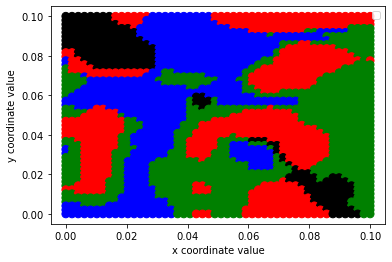

In [40]:
gmm_granite_2 = GaussianMixture(n_components = 4) 
gmm_granite_2.fit(new_dataset)
predict = gmm_granite_2.predict(new_dataset)
new_dataset['label'] = pd.Series(predict, index=new_dataset.index)
new_dataset.columns = ['X', 'Y', 'Hardness', 'Modulus', 'label']
# print(new_dataset['label'].min(), new_dataset['label'].max())


LABEL_COLOR_MAP = {0 : 'blue',
                   1 : 'green',
                   2 : 'red',
                   3 : 'black'}


label_color = [LABEL_COLOR_MAP[l] for l in new_dataset['label']]

new_dataset.index = np.arange(1, len(new_dataset) + 1)
new_dataset.head()

plt.scatter(new_dataset["X"], new_dataset["Y"], c = label_color, s = 60)

    
plt.legend()
plt.xlabel("x coordinate value")
plt.ylabel("y coordinate value")